In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def clean_data(dataframe):
    dataframe.drop(columns='Unnamed: 0', inplace=True)
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    
    dataframe['sale_year'] = pd.DatetimeIndex(dataframe['date']).year
    dataframe['sale_month'] = pd.DatetimeIndex(dataframe['date']).month
    
    #replace 33 bedrooms with correct value
    training_data.set_value(8597, 'bedrooms', 3)
    

    return dataframe.head(5)

def no_bedrooms(dataframe, df2):
    index=dataframe.loc[dataframe.bedrooms == 0].index.to_list()
    dataframe.drop(dataframe.index[[index]], inplace=True)
    frames= [dataframe, df2]
    dataframe = pd.concat(frames)
    print(dataframe.shape)
    return dataframe

def price_distribution(dataframe):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.hist(dataframe['price'], bins=100);
    ax.set_title('Housing Prices');
    
def multicolinear_features(data):
    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc']
    return df[(df.cc>.75) & (df.cc <1)]
    
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
missing_vals = pd.read_csv('bedroomsfilled.csv')
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
zipcode_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
clean_data(training_data)
clean_data(missing_vals)
training_data = no_bedrooms(training_data, missing_vals)
training_data

(17290, 23)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,3
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2954400190,2014-06-24,1295650.0,4,4.50,4810,28008,2.0,0,0,...,0,1990,0,98053,47.6642,-122.069,4740,35061,2014,6
8,3980300371,2014-09-26,142000.0,1,0.75,290,20875,1.0,0,0,...,0,1954,0,98024,47.5308,-121.888,1620,22850,2014,9
9,2310060040,2014-09-25,240000.0,4,2.50,1810,5669,2.0,0,0,...,0,2003,0,98038,47.3493,-122.053,1810,5685,2014,9
10,6896300380,2014-10-02,228000.0,2,1.00,390,5900,1.0,0,0,...,0,1953,0,98118,47.5260,-122.261,2170,6000,2014,10


In [3]:
training_data.loc[training_data['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month


# Extra Zip Code Data

In [4]:
zipcode_data.set_index('zipcode', inplace=True)

In [5]:
zipcode_data.head(3)

,population,postoffice,pop_density,occupied_housing_units,median_household_income,median_home_value,total_housing_units,land_area,water_area_sq_mile,owned_household_with_mortgage,renter_occupied_households,houses_owned_outright,sold_and_unoccupied,seasonal_or_rec_use
zipcode,,,,,,,,,,,,,,
98001,33169,Auburn,1717,10717,71746,268800,11249,18.59,0.32,6975,2373,1369,21,33
98002,32895,Auburn,4423,12495,43568,167100,13480,7.15,0.13,3970,6533,1992,28,38
98003,45892,FederalWay,3800,17250,45894,221600,98003,11.62,0.11,6313,8770,2167,39,67


In [6]:
training_data.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8


In [7]:
training_data = pd.merge(training_data, zipcode_data, how='right', on='zipcode')
training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

In [8]:
training_data.drop(columns='date', inplace=True)

In [9]:
training_data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,median_home_value,total_housing_units,land_area,water_area_sq_mile,owned_household_with_mortgage,renter_occupied_households,houses_owned_outright,sold_and_unoccupied,seasonal_or_rec_use,available_housing
0,2591820310,365000.0,4,2.25,2070,8893,2.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
1,5112800060,455000.0,4,1.75,2050,94525,1.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
2,1423400260,273000.0,3,1.75,2050,9045,2.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
3,1423200170,223000.0,2,1.00,910,9869,1.0,0,0,3,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
4,1402100070,335500.0,5,3.00,2240,19090,1.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725


# Identify Problematic Outliers

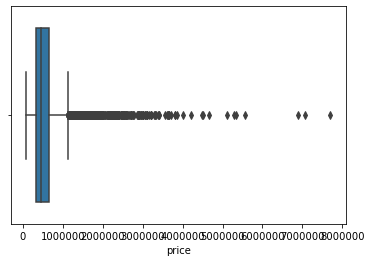

In [10]:
sns.boxplot(x=training_data['price'])

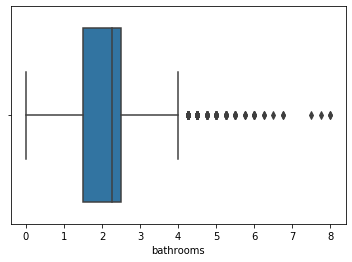

In [11]:
sns.boxplot(x=training_data['bathrooms'])

In [12]:
def remove_outliers(dataframe, feature):
    
    Q1 = dataframe[feature].quantile(.25)
    Q3 = dataframe[feature].quantile(.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    dataframe.drop(dataframe[(dataframe[feature] > upper_b) | (dataframe[feature] < lower_b)].index , inplace=True)
    print('Removed {} outliers above or below {}, {}'.format(feature, lower_range, upper_range))


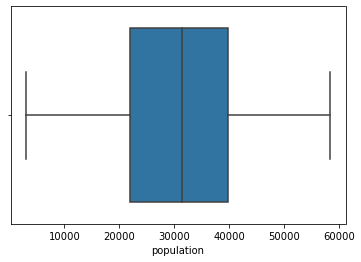

In [13]:
sns.boxplot(x=training_data['population'])

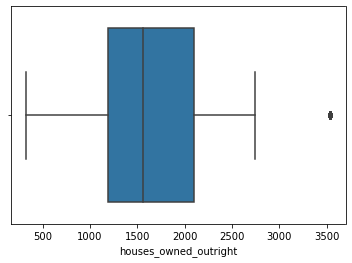

In [14]:
sns.boxplot(x=training_data['houses_owned_outright'])

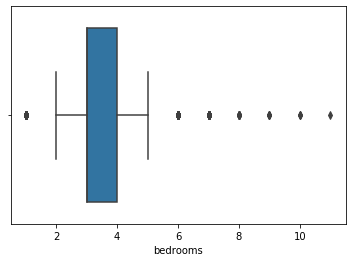

In [15]:
sns.boxplot(x=training_data['bedrooms'])

# Log Transform Sqft Data

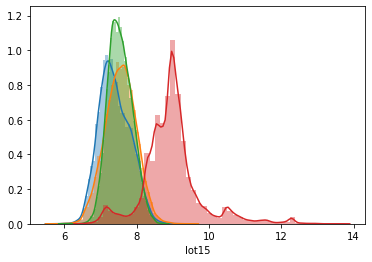

In [16]:
data_log = pd.DataFrame([])
data_log['above'] = np.log(training_data['sqft_above'])
data_log['living15'] = np.log(training_data['sqft_living15'])
data_log['lot15'] = np.log(training_data['sqft_lot15'])
data_log['living'] = np.log(training_data['sqft_living'])
sns.distplot(data_log['above']);
sns.distplot(data_log['living']);
sns.distplot(data_log['living15']);
sns.distplot(data_log['lot15']);

# Min/Max Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

beds = training_data['bedrooms']
beds_max = max(training_data['bedrooms'])
beds_min = min(training_data['bedrooms'])
baths = training_data['bathrooms']
baths_max = max(training_data['bathrooms'])
baths_min = min(training_data['bathrooms'])
income = training_data['median_household_income']
income_max = max(training_data['median_household_income'])
income_min = min(training_data['median_household_income'])
median_home_val = training_data['median_home_value']
median_home_val_max = max(training_data['median_home_value'])
median_home_val_min = min(training_data['median_home_value'])

training_data['bedrooms'] = (beds - beds_min)/(beds_max-beds_min)
training_data['bathrooms'] = (baths - baths_min)/(baths_max-baths_min)
training_data['median_household_income'] = (income - income_min)/(income_max - income_min)
training_data['median_home_value'] = (median_home_val - median_home_val_min)/(median_home_val_max - median_home_val_min)



training_data[['pop_density','sqft_living15', 'sqft_above', 'sqft_basement', 'sqft_lot']] = scaler.fit_transform(training_data[['pop_density','sqft_living15', 'sqft_above', 'sqft_basement', 'sqft_lot']])  

# Dummies

In [18]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)


training_data = training_data.drop(['id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)
training_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,365000.0,0.3,0.28125,2070,0.005041,2.0,0.195175,0.000000,1986,0,...,0,0,0,0,0,0,0,0,0,0
1,455000.0,0.3,0.21875,2050,0.056914,1.0,0.105263,0.165975,1959,0,...,0,0,0,0,0,0,0,0,0,0
2,273000.0,0.2,0.21875,2050,0.005133,2.0,0.192982,0.000000,1959,0,...,0,0,0,0,0,0,0,0,0,0
3,223000.0,0.1,0.12500,910,0.005632,1.0,0.067982,0.000000,1957,0,...,0,0,0,0,0,0,0,0,0,0
4,335500.0,0.4,0.37500,2240,0.011218,1.0,0.154605,0.112033,1968,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,0.3,0.46875,4150,0.010208,1.0,0.311404,0.211618,1963,2000,...,0,0,0,0,0,0,0,0,0,0
17286,2450000.0,0.6,0.53125,4670,0.013656,2.0,0.480263,0.000000,1992,0,...,0,0,0,0,0,0,0,0,0,0
17287,2100000.0,0.3,0.21875,3550,0.011687,2.0,0.357456,0.000000,1962,2002,...,0,0,0,0,0,0,0,0,0,0
17288,1620000.0,0.3,0.28125,2350,0.010381,2.0,0.225877,0.000000,1977,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
training_data.drop(['zip_98003','owned_household_with_mortgage', 'houses_owned_outright','land_area','occupied_housing_units', 'total_housing_units','sqft_living', 'condition_3'], axis=1, inplace=True)

# Colinnear Features

In [20]:
multicolinear_features(training_data)

,cc
pairs,


# from sklearn.model_selection import train_test_split

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

y = training_data.price
x = training_data.drop(['price', 'postoffice'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 120), (3458, 120))

In [22]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
np.sqrt(MSE)

139487.47088671627

In [23]:
np.mean(cross_val_score(estimator=lr, X=x_train, y=y_train, cv=10))

0.82795101173985

In [24]:
y_hat[230], y_test.to_list()[230]

(314696.9679887891, 380000.0)

# OLS

In [25]:
training_data['pop_density']

0        0.137700
1        0.137700
2        0.137700
3        0.137700
4        0.137700
           ...   
17285    0.127819
17286    0.127819
17287    0.127819
17288    0.127819
17289    0.127819
Name: pop_density, Length: 17290, dtype: float64

In [26]:
outcome = 'price'
predictors = training_data.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
model = ols(formula= formula, data=training_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     791.2
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:14:41   Log-Likelihood:            -2.3065e+05
No. Observations:               17290   AIC:                         4.615e+05
Df Residuals:                   17177   BIC:                         4.624e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.216e+08    1.3e+07     -9.342      0.000   -1.47e+08   -9.61e+07
postoffice[T.	Renton]      -2.082e+06   2.24e+05     -9.299      0.000   -2.52e+06   -1.64e+06
postoffice[T.	Seattle]     -6.718e+06   7.21e+05     -9.317      0.000   -8.13e+06    -5.3e+06
postoffice[T.Auburn]       -7.588e+06   8.19e+05     -9.264      0.000   -9.19e+06   -5.98e+06
postoffice[T.Bellevue]     -4.124e+06    4.5e+05     -9.169      0.000   -5.01e+06   -3.24e+06
postoffice[T.BlackDiamond] -1.136e+07   1.22e+06     -9.346      0.000   -1.37e+07   -8.98e+06
postoffice[T.Bothell]      -5.182e+06   5.56e+05     -9.325      0.000   -6.27e+06   -4.09e+06
postoffice[T.Carnation]    -9.465e+06   1.01e+06     -9.370      0.000   -1.14e+07   -7.48e+06
postoffice[T.Duvall]       -9.498e+06   1.01e+06     -9.376      0.000   -1.15e+07   -7.51e+06
postoffice[T.Enumclaw]     -3.828e+06   4.08e+05     -9.381      0.000   -4.63e+06   -3.03e+06
postoffice[T.FallCity]     -1.057e+07   1.13e+06     -9.361      0.000   -1.28e+07   -8.36e+06
postoffice[T.FederalWay]    2.403e+05   3.02e+04      7.967      0.000    1.81e+05    2.99e+05
postoffice[T.Issaquah]     -5.864e+06   6.26e+05     -9.364      0.000   -7.09e+06   -4.64e+06
postoffice[T.Kenmore]      -6.175e+06    6.6e+05     -9.357      0.000   -7.47e+06   -4.88e+06
postoffice[T.Kent]         -6.169e+06   6.61e+05     -9.337      0.000   -7.46e+06   -4.87e+06
postoffice[T.Kirkland]     -3.804e+04   1.01e+04     -3.750      0.000   -5.79e+04   -1.82e+04
postoffice[T.MapleValley]   -3.53e+06   3.78e+05     -9.344      0.000   -4.27e+06   -2.79e+06
postoffice[T.Medina]        8.951e+05   6.46e+04     13.866      0.000    7.69e+05    1.02e+06
postoffice[T.MercerIsland]  3.854e+06    4.1e+05      9.394      0.000    3.05e+06    4.66e+06
postoffice[T.NorthBend]    -6.566e+06   7.02e+05     -9.353      0.000   -7.94e+06   -5.19e+06
postoffice[T.Redmond]      -3.111e+04   5636.430     -5.520      0.000   -4.22e+04   -2.01e+04
postoffice[T.Renton]       -6.501e+06   6.94e+05     -9.361      0.000   -7.86e+06   -5.14e+06
postoffice[T.Sammamish]     8.206e+05   9.48e+04      8.655      0.000    6.35e+05    1.01e+06
postoffice[T.Seattle]      -1.154e+07   1.23e+06     -9.346      0.000    -1.4e+07   -9.12e+06
postoffice[T.Snoqualmie]   -7.691e+06   8.16e+05     -9.424      0.000   -9.29e+06   -6.09e+06
postoffice[T.Vashon]        3.219e+05   4.58e+04      7.035      0.000    2.32e+05    4.12e+05
postoffice[T.Woodinville]  -5.439e+06   5.75e+05     -9.463      0.000   -6.57e+06   -4.31e+06
bedrooms                   -1.337e+05   1.71e+04     -7.807      0.000   -1.67e+05      -1e+05
bathrooms                   1.933e+05   2.23e+04      8.666      0.000     1.5e+05    2.37e+05
sqft_lot                    3.402e+05   6.3

# Recursive Feature Selection

In [29]:
rfe = RFE(estimator=lr, n_features_to_select=50, step=1)
rfe = rfe.fit(x_train, y_train)
rfe

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=50, step=1, verbose=0)

In [30]:
selected_rfe_features= pd.DataFrame({'Feature': list(x_train.columns),
                                    'Ranking': rfe.ranking_})

selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
59,zip_98011,1
93,zip_98105,1
92,zip_98103,1
91,zip_98102,1
78,zip_98052,1
...,...,...
6,yr_built,67
7,yr_renovated,68
13,population,69
21,available_housing,70
